**Load Module**

In [1]:
# Utils
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import time
from datetime import datetime
from utility.utils import EarlyStopping, WarmUpLR, most_recent_folder, most_recent_weights, best_acc_weights, last_epoch
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler


import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter

# Analysis
from sklearn.metrics import confusion_matrix, classification_report
import wandb


**Seed Setting**

In [2]:
random.seed(0)

**Device Setting**

In [3]:
# 디바이스 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Wandb Setting**

In [4]:
config = {
    "batch_size" : 128,
    "num_epochs" : 10,
    "learning_rate" : 0.1,
    "momentum" : 0.9,
    "weight_decay" : 5e-4,
    "gamma" : 0.2,
    "warm" : 1,
    "patience" : 150,
    "milestones" : [60, 120, 210, 300]
}

In [5]:
wandb.init(project="CIFAR-100_Classification", name="ResNet_18", config=config)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hyunwook7120 (hyunwook7120-hanyang-university). Use `wandb login --relogin` to force relogin


**Set Hyperparameters**

In [6]:
batch_size = 128
num_epochs = 10
learning_rate = 0.1
momentum = 0.9
weight_decay = 5e-4
gamma = 0.2
warm = 1
patience = 150

milestones = [60, 120, 210, 300]
save_epoch = 10
resume = False

##### **fine_to_superclass**

In [7]:
fine_to_superclass = {
    # aquatic mammals
    4: 0, 30: 0, 55: 0, 72: 0, 95: 0,
    
    # fish
    1: 1, 32: 1, 67: 1, 73: 1, 91: 1,
    
    # flowers
    54: 2, 62: 2, 70: 2, 82: 2, 92: 2,
    
    # food containers
    9: 3, 10: 3, 16: 3, 28: 3, 61: 3,
    
    # fruit and vegetables
    0: 4, 51: 4, 53: 4, 57: 4, 83: 4,
    
    # household electrical devices
    22: 5, 39: 5, 40: 5, 86: 5, 87: 5,
    
    # household furniture
    5: 6, 20: 6, 25: 6, 84: 6, 94: 6,
    
    # insects
    6: 7, 7: 7, 14: 7, 18: 7, 24: 7,
    
    # large carnivores
    3: 8, 42: 8, 43: 8, 88: 8, 97: 8,
    
    # large man-made outdoor things
    12: 9, 17: 9, 37: 9, 68: 9, 76: 9,
    
    # large natural outdoor scenes
    23: 10, 33: 10, 49: 10, 60: 10, 71: 10,
    
    # large omnivores and herbivores
    15: 11, 19: 11, 21: 11, 31: 11, 38: 11,
    
    # medium-sized mammals
    34: 12, 63: 12, 64: 12, 66: 12, 75: 12,
    
    # non-insect invertebrates
    26: 13, 45: 13, 77: 13, 79: 13, 99: 13,
    
    # people
    2: 14, 11: 14, 35: 14, 46: 14, 98: 14,
    
    # reptiles
    27: 15, 29: 15, 44: 15, 78: 15, 93: 15,
    
    # small mammals
    36: 16, 50: 16, 65: 16, 74: 16, 80: 16,
    
    # trees
    47: 17, 52: 17, 56: 17, 59: 17, 96: 17,
    
    # vehicles 1
    8: 18, 13: 18, 48: 18, 58: 18, 90: 18,
    
    # vehicles 2
    41: 19, 69: 19, 81: 19, 85: 19, 89: 19
}

# Data Preprocessing

In [8]:
CIFAR100_TRAIN_MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
CIFAR100_TRAIN_STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

train_val_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4), 
    transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_TRAIN_MEAN, CIFAR100_TRAIN_STD)
])

**Splitting the training data**

In [9]:
train_val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_val_transform)
val_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=test_transform)
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
# train 데이터를 train/val로 나누기
num_train = len(train_val_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # validation 데이터를 20%로 설정

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

**Define Dataloader**

In [11]:
train_loader = DataLoader(train_val_data, batch_size=batch_size, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(train_val_data, batch_size=batch_size, shuffle=False, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

**Training Loop**

In [12]:
from models import resnet

print("use:", device)

# 모델 초기화
# net = Net()
net = resnet.resnet18()
net_name = "resnet_18"
# 모델을 GPU로 이동
net.to(device)

print(summary(net, (3,224,224)))

use: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,728
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,864
       BatchNorm2d-8         [-1, 64, 224, 224]             128
        BasicBlock-9         [-1, 64, 224, 224]               0
           Conv2d-10         [-1, 64, 224, 224]          36,864
      BatchNorm2d-11         [-1, 64, 224, 224]             128
             ReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]          36,864
      BatchNorm2d-14       

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.2) #learning rate decay
iter_per_epoch = len(train_loader)
warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * warm)

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.0005, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'initial_lr': 0.1, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]}]


In [14]:
DATE_FORMAT = '%A_%d_%B_%Y_%Hh_%Mm_%Ss'
TIME_NOW = datetime.now().strftime(DATE_FORMAT)

if resume:
    recent_folder = most_recent_folder(os.path.join("runs", net_name, "savepoints"), DATE_FORMAT)
    if not recent_folder:
        raise Exception("no recent folder were found")

    checkpoint_path = os.path.join("runs", net_name, "savepoints", recent_folder)
else:
    checkpoint_path = os.path.join("runs", net_name, "savepoints", TIME_NOW)

In [15]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint_path = os.path.join(checkpoint_path, '{net}-{epoch}-{type}.pth')

**Model Train**

In [16]:
writer = SummaryWriter(log_dir=os.path.join("runs", net_name, "tensorboard", TIME_NOW))
writer.add_graph(net, torch.Tensor(1,3,32,32).cuda())

In [17]:
best_acc = 0.0

if resume:
    best_weights = best_acc_weights(os.path.join("runs", net_name, "savepoints", recent_folder))
    if best_weights:
        weights_path = os.path.join("runs", net_name, "savepoints", recent_folder, best_weights)
        print('found best acc weights file:{}'.format(weights_path))
        print('load best training file to test acc...')
        net.load_state_dict(torch.load(weights_path))
        best_acc = eval_training(net, test_loader, criterion, epoch)
        print("best acc is {:0.2f}".format(best_acc))

    recent_weights_file = most_recent_weights(os.path.join("runs", net_name, "savepoints", recent_folder))
    if not recent_weights_file:
        raise Exception("no recent weights file were found")
    weights_path = os.path.join("runs", net_name, "savepoints", recent_folder, recent_weights_file)
    print("loading weights file {} to resume training......".format(weights_path))
    net.load_state_dict(torch.load(weights_path))

    resume_epoch = last_epoch(os.path.join("runs", net_name, "savepoints", recent_folder))

In [18]:
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [19]:
# 모델 학습 함수
def train_model(net, trainloader, criterion, optimizer, epoch):
    start = time.time()
    net.train()
    
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        labels = labels.to(device)
        inputs = inputs.to(device)

        optimizer.zero_grad()

        # 모델 예측
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        n_iter = (epoch - 1) * len(train_loader) + batch_idx + 1
        running_loss += loss.item() * inputs.size(0)

        # 30번째 배치마다 상태 출력
        if (batch_idx + 1) % 30 == 0:
            print(f"Batch [{batch_idx+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        if epoch <= warm:
            warmup_scheduler.step()


    # Epoch당 평균 손실 계산 및 출력
    epoch_loss = running_loss / len(trainloader.dataset)
    writer.add_scalar("Train/loss", epoch_loss, epoch)
    # print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
    # warmup 적용 확인

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
    # # Early Stopping 체크
    # early_stopping(epoch_loss, net)
    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break


    finish = time.time()

    print('epoch {} training time consumed: {:.2f}s'.format(epoch, finish - start))

    return epoch_loss

**Model Test**

In [20]:
def eval_training(net, testloader, criterion, epoch):
    correct_1_fine = 0.0  # 세부 클래스 top-1 정확도
    correct_5_fine = 0.0  # 세부 클래스 top-5 정확도
    correct_1_super = 0.0  # 슈퍼 클래스 top-1 정확도
    total = 0
    
    start = time.time()
    net.eval()
    
    test_loss = 0.0
    
    with torch.no_grad():
        for n_iter, (image, label) in enumerate(testloader):
            
            image = image.cuda()
            label = label.cuda()

            # 모델 예측
            output = net(image)
            _, pred = output.topk(5, 1, largest=True, sorted=True)

            test_loss += criterion(output, label)

            label = label.view(label.size(0), -1).expand_as(pred)
            correct = pred.eq(label).float()


            # 세부 클래스 top-5 정확도
            correct_5_fine += correct[:, :5].sum()
            # 세부 클래스 top-1 정확도
            correct_1_fine += correct[:, :1].sum()
    
            # 슈퍼 클래스 변환 (contiguous()로 메모리 연속성 확보 후 view() 사용)
            target_super = torch.tensor([fine_to_superclass[t.item()] for t in label.contiguous().view(-1)], device=device)
            pred_super = torch.tensor([fine_to_superclass[p.item()] for p in pred.contiguous().view(-1)], device=device).view_as(pred)
    
            # target_super를 pred_super의 크기로 확장
            target_super = target_super.view(label.size(0), 5).expand_as(pred_super)
    
            # 슈퍼 클래스 top-1 정확도만 계산
            correct_super = pred_super.eq(target_super).float()
            correct_1_super += correct_super[:, :1].sum()
    
            total += label.size(0)

    finish = time.time()
    average_loss = test_loss / total

    # 세부 클래스 및 슈퍼 클래스 정확도 계산
    top1_acc_fine = correct_1_fine / total
    top5_acc_fine = correct_5_fine / total
    top1_acc_super = correct_1_super / total
    accuracy = [top1_acc_fine, top5_acc_fine, top1_acc_super]
    
    print("Test set: Epoch: {}, Average loss:{:.4f}, Top-1 Accuracy: {:.4f}, Top-5 Accuracy: {:.4f}, Super-1 Accuracy: {:.4f}, Time consumed:{:.2f}s".format(
        epoch,
        average_loss,
        top1_acc_fine,
        top5_acc_fine,
        top1_acc_super,
        finish - start
    ))
    print()
    # TensorBoard에 테스트 손실 및 정확도 기록
    writer.add_scalar("Test/Average Loss", average_loss, epoch)
    writer.add_scalar("Test/Accuracy", top1_acc_fine, epoch)
    writer.add_scalar("Test/Accuracy", top5_acc_fine, epoch)
    writer.add_scalar("Test/Accuracy", top1_acc_super, epoch)

    return average_loss, accuracy

**Per-Epoch Training**

In [21]:
# for epoch in tqdm(range(1, num_epochs + 1)):
#     train_model(net, train_loader, criterion, optimizer, num_epochs=num_epochs)
#     test_loss, test_accuracy = test_model(net, test_loader, criterion, epoch)
#     writer.add_scalar("Test Loss", test_loss, epoch)
#     writer.add_scalar("Test Accuracy", test_accuracy, epoch)
#     print(f"Processing Result = Epoch : {epoch}   Loss : {test_loss}   Accuracy : {test_accuracy}")
#     writer.close()

In [22]:
start_time = time.time()
for epoch in tqdm(range(1, num_epochs + 1)):
    if epoch > warm:
        train_scheduler.step()

    if resume:
        if epoch <= resume_epoch:
            continue

    epoch_loss = train_model(net, train_loader, criterion, optimizer, epoch=epoch)
    test_loss, test_accuracy = eval_training(net, val_loader, criterion, epoch)

    if epoch > milestones[1] and best_acc < test_accuracy[0]:
        weights_path = checkpoint_path.format(net=net_name, epoch=epoch, type="best")
        print("saving weights file to {}".format(weights_path))
        torch.save(net.state_dict(), weights_path)
        best_acc = test_accuracy[0]
        continue

    if not epoch % save_epoch:
        weights_path = checkpoint_path.format(net=net_name, epoch=epoch, type="regular")
        print("saving weights file to {}".format(weights_path))
        torch.save(net.state_dict(), weights_path)

    early_stopping(test_loss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    wandb.log({
        "epoch": epoch,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "train_loss": epoch_loss,
        "val_loss": test_loss,
        "top-1 accuracy": test_accuracy[0],
        "top-5 accuracy": test_accuracy[1],
        "top1_acc_super": test_accuracy[2]
    })

writer.close()
end_time = time.time()
wandb.log({"train_time": end_time - start_time})

  0%|          | 0/10 [00:00<?, ?it/s]

Batch [30/313], Loss: 4.3153
Batch [60/313], Loss: 4.1813
Batch [90/313], Loss: 3.9483
Batch [120/313], Loss: 3.9686
Batch [150/313], Loss: 3.9984
Batch [180/313], Loss: 4.0169
Batch [210/313], Loss: 3.7742
Batch [240/313], Loss: 3.7864
Batch [270/313], Loss: 3.6045
Batch [300/313], Loss: 3.6958
Epoch [1/10], Loss: 3.2252, LR: 0.100000
epoch 1 training time consumed: 33.08s


 10%|█         | 1/10 [00:47<07:03, 47.05s/it]

Test set: Epoch: 1, Average loss:0.0300, Top-1 Accuracy: 0.1161, Top-5 Accuracy: 0.3395, Super-1 Accuracy: 0.2243, Time consumed:13.96s

Batch [30/313], Loss: 3.9584
Batch [60/313], Loss: 3.7803
Batch [90/313], Loss: 3.3958
Batch [120/313], Loss: 3.7486
Batch [150/313], Loss: 3.3639
Batch [180/313], Loss: 3.5111
Batch [210/313], Loss: 3.3018
Batch [240/313], Loss: 3.1357
Batch [270/313], Loss: 3.3832
Batch [300/313], Loss: 3.0751
Epoch [2/10], Loss: 2.7209, LR: 0.100000
epoch 2 training time consumed: 33.02s


 20%|██        | 2/10 [01:34<06:16, 47.00s/it]

Test set: Epoch: 2, Average loss:0.0256, Top-1 Accuracy: 0.2026, Top-5 Accuracy: 0.4880, Super-1 Accuracy: 0.3434, Time consumed:13.95s

Batch [30/313], Loss: 3.1404
Batch [60/313], Loss: 2.9338
Batch [90/313], Loss: 3.2298
Batch [120/313], Loss: 3.0211
Batch [150/313], Loss: 2.9605
Batch [180/313], Loss: 3.0126
Batch [210/313], Loss: 2.9142
Batch [240/313], Loss: 3.1192
Batch [270/313], Loss: 2.6655
Batch [300/313], Loss: 2.7708
Epoch [3/10], Loss: 2.3884, LR: 0.100000
epoch 3 training time consumed: 33.03s


 30%|███       | 3/10 [02:21<05:29, 47.01s/it]

Test set: Epoch: 3, Average loss:0.0239, Top-1 Accuracy: 0.2469, Top-5 Accuracy: 0.5598, Super-1 Accuracy: 0.3979, Time consumed:14.00s

Batch [30/313], Loss: 2.6469
Batch [60/313], Loss: 2.8357
Batch [90/313], Loss: 2.6769
Batch [120/313], Loss: 2.6504
Batch [150/313], Loss: 2.5473
Batch [180/313], Loss: 2.7740
Batch [210/313], Loss: 2.8205
Batch [240/313], Loss: 2.5035
Batch [270/313], Loss: 2.4920
Batch [300/313], Loss: 2.2648
Epoch [4/10], Loss: 2.1233, LR: 0.100000
epoch 4 training time consumed: 32.99s


 40%|████      | 4/10 [03:07<04:41, 46.91s/it]

Test set: Epoch: 4, Average loss:0.0213, Top-1 Accuracy: 0.3106, Top-5 Accuracy: 0.6345, Super-1 Accuracy: 0.4493, Time consumed:13.75s

Batch [30/313], Loss: 2.5073
Batch [60/313], Loss: 2.1984
Batch [90/313], Loss: 2.4424
Batch [120/313], Loss: 2.2656
Batch [150/313], Loss: 2.3929
Batch [180/313], Loss: 2.4953
Batch [210/313], Loss: 2.4529
Batch [240/313], Loss: 2.2947
Batch [270/313], Loss: 2.0929
Batch [300/313], Loss: 2.5357
Epoch [5/10], Loss: 1.8942, LR: 0.100000
epoch 5 training time consumed: 33.03s


 50%|█████     | 5/10 [03:54<03:54, 46.95s/it]

Test set: Epoch: 5, Average loss:0.0202, Top-1 Accuracy: 0.3440, Top-5 Accuracy: 0.6741, Super-1 Accuracy: 0.4948, Time consumed:13.99s

Batch [30/313], Loss: 2.2847
Batch [60/313], Loss: 2.0244
Batch [90/313], Loss: 2.2961
Batch [120/313], Loss: 2.4247
Batch [150/313], Loss: 2.2071
Batch [180/313], Loss: 2.0467
Batch [210/313], Loss: 1.9506
Batch [240/313], Loss: 2.0761
Batch [270/313], Loss: 2.0861
Batch [300/313], Loss: 2.2189
Epoch [6/10], Loss: 1.7124, LR: 0.100000
epoch 6 training time consumed: 33.02s


 60%|██████    | 6/10 [04:42<03:08, 47.09s/it]

Test set: Epoch: 6, Average loss:0.0196, Top-1 Accuracy: 0.3570, Top-5 Accuracy: 0.6876, Super-1 Accuracy: 0.5045, Time consumed:14.33s

Batch [30/313], Loss: 1.8465
Batch [60/313], Loss: 1.8211
Batch [90/313], Loss: 1.8259
Batch [120/313], Loss: 1.9028
Batch [150/313], Loss: 1.9318
Batch [180/313], Loss: 2.1981
Batch [210/313], Loss: 1.8720
Batch [240/313], Loss: 2.1554
Batch [270/313], Loss: 1.9436
Batch [300/313], Loss: 1.9184
Epoch [7/10], Loss: 1.5885, LR: 0.100000
epoch 7 training time consumed: 33.04s


 70%|███████   | 7/10 [05:28<02:20, 46.98s/it]

Test set: Epoch: 7, Average loss:0.0181, Top-1 Accuracy: 0.3998, Top-5 Accuracy: 0.7197, Super-1 Accuracy: 0.5484, Time consumed:13.73s

Batch [30/313], Loss: 1.8691
Batch [60/313], Loss: 1.8018
Batch [90/313], Loss: 1.9008
Batch [120/313], Loss: 2.0092
Batch [150/313], Loss: 1.9465
Batch [180/313], Loss: 2.0636
Batch [210/313], Loss: 1.6821
Batch [240/313], Loss: 1.8193
Batch [270/313], Loss: 1.9168
Batch [300/313], Loss: 2.0526
Epoch [8/10], Loss: 1.4922, LR: 0.100000
epoch 8 training time consumed: 32.91s


 80%|████████  | 8/10 [06:16<01:34, 47.06s/it]

Test set: Epoch: 8, Average loss:0.0178, Top-1 Accuracy: 0.4111, Top-5 Accuracy: 0.7358, Super-1 Accuracy: 0.5573, Time consumed:14.30s

Batch [30/313], Loss: 1.8365
Batch [60/313], Loss: 1.5949
Batch [90/313], Loss: 1.7529
Batch [120/313], Loss: 1.8720
Batch [150/313], Loss: 2.0470
Batch [180/313], Loss: 1.6962
Batch [210/313], Loss: 1.8950
Batch [240/313], Loss: 1.6758
Batch [270/313], Loss: 1.5877
Batch [300/313], Loss: 1.5158
Epoch [9/10], Loss: 1.4264, LR: 0.100000
epoch 9 training time consumed: 32.88s


 90%|█████████ | 9/10 [07:03<00:47, 47.00s/it]

Test set: Epoch: 9, Average loss:0.0181, Top-1 Accuracy: 0.4083, Top-5 Accuracy: 0.7247, Super-1 Accuracy: 0.5539, Time consumed:14.01s

EarlyStopping counter: 1 out of 150
Batch [30/313], Loss: 1.6793
Batch [60/313], Loss: 1.7204
Batch [90/313], Loss: 1.7957
Batch [120/313], Loss: 1.7406
Batch [150/313], Loss: 1.4875
Batch [180/313], Loss: 1.5801
Batch [210/313], Loss: 1.6209
Batch [240/313], Loss: 1.9725
Batch [270/313], Loss: 1.8985
Batch [300/313], Loss: 1.6457
Epoch [10/10], Loss: 1.3630, LR: 0.100000
epoch 10 training time consumed: 33.21s


100%|██████████| 10/10 [07:50<00:00, 47.01s/it]

Test set: Epoch: 10, Average loss:0.0171, Top-1 Accuracy: 0.4330, Top-5 Accuracy: 0.7461, Super-1 Accuracy: 0.5679, Time consumed:13.84s

saving weights file to runs\resnet_18\savepoints\Monday_30_September_2024_23h_11m_46s\resnet_18-10-regular.pth


**Result**

In [44]:
print(f" Result of ResNet = Epoch : {epoch}   Loss : {test_loss:.4f}   Top-1 Accuracy : {test_accuracy[0]*100:.4f}%  Top-5 Accuracy : {test_accuracy[1]*100:.4f}%   Super Accuracy : {test_accuracy[2]*100:.4f}%   Total_Accuracy : {sum(test_accuracy)*100:.4f}    Time : {end_time - start_time:.4f}")

 Result of ResNet = Epoch : 10   Loss : 0.0171   Top-1 Accuracy : 43.3000%  Top-5 Accuracy : 74.6100%   Super Accuracy : 56.7900%   Total_Accuracy : 174.7000    Time : 470.1497


In [24]:
# torch.save(net, "resnet_18.pt")

**Data Analysis**

In [45]:
%load_ext tensorboard
%tensorboard --logdir=./runs/resnet_18/tensorboard --port=8203 --host=0.0.0.0

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8203 (pid 24260), started 0:19:31 ago. (Use '!kill 24260' to kill it.)

**Classes**

In [26]:
classes = train_val_data.classes
coarse_classes = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 
    'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 
    'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 
    'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]
print(len(classes), len(coarse_classes))

100 20


##### **Confusion Matrix**

In [27]:
# y_pred = []
# y_true = []

# # iterate over test data
# for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    
#     #print('iter val', i)
#     x = x.to(device)
#     y = y.to(device)
#     z = net(x)
#     _, yhat = torch.max(z, 1)
#     pred = yhat.data.cpu().numpy()
#     y_pred.extend(pred) # Save Prediction

#     labels = y.data.cpu().numpy()
#     y_true.extend(labels) # Save Truth

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (128,70))
# sns.heatmap(df_cm, annot=True)
# plt.title('Confusion Matrix of ResNet (CIFAR100)')
# plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100.jpg')

In [28]:
# print(f" Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

**Confusion Matrix - Coarse**

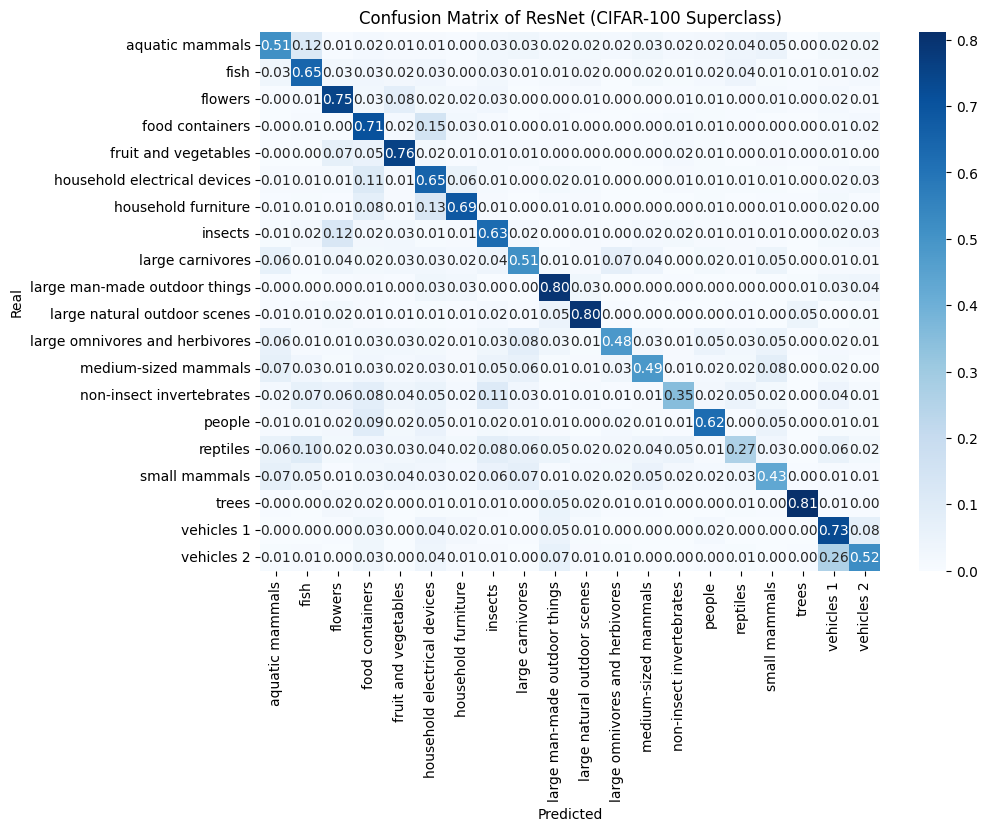

In [31]:
import wandb.sklearn


y_pred = []
y_true = []

# iterate over test data
for x, y in torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size):
    x = x.to(device)
    y = y.to(device)
    z = net(x)
    _, yhat = torch.max(z, 1)
    
    # Save Prediction and convert to superclasses
    pred = yhat.data.cpu().numpy()
    super_pred = [fine_to_superclass[p] for p in pred]
    y_pred.extend(super_pred)
    
    # Save Truth and convert to superclasses
    labels = y.data.cpu().numpy()
    super_labels = [fine_to_superclass[l] for l in labels]
    y_true.extend(super_labels)

# Build confusion matrix for superclasses
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Normalize confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=coarse_classes,
                     columns=coarse_classes)
wandb.log({"conf_mat": wandb.plot.confusion_matrix(probs=None,
                    y_true=y_true, preds=y_pred,
                    class_names=coarse_classes)})
wandb.sklearn.plot_confusion_matrix(y_true,y_pred,labels=coarse_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix of ResNet (CIFAR-100 Superclass)')
plt.savefig('./runs/resnet_18/Confusion_matrix_ResNet_Cifar100_superclass.jpg')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.show()

**Classification Report**

In [42]:
print(f"Super Classification Report of ResNet(CIFAR100)  \n { classification_report(y_true, y_pred)}")

Super Classification Report of ResNet(CIFAR100)  
               precision    recall  f1-score   support

           0       0.54      0.51      0.53       500
           1       0.58      0.65      0.61       500
           2       0.61      0.75      0.67       500
           3       0.48      0.71      0.58       500
           4       0.66      0.76      0.71       500
           5       0.47      0.65      0.54       500
           6       0.69      0.69      0.69       500
           7       0.53      0.63      0.57       500
           8       0.55      0.51      0.53       500
           9       0.65      0.80      0.72       500
          10       0.76      0.80      0.78       500
          11       0.69      0.48      0.57       500
          12       0.64      0.49      0.55       500
          13       0.63      0.35      0.45       500
          14       0.71      0.62      0.67       500
          15       0.49      0.27      0.35       500
          16       0.53      0

In [ ]:
wandb.finish()